In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pandas as pd

from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

from scipy.linalg import lstsq
from scipy.optimize import curve_fit

import lightkurve as lk
import tessreduce as tr

import pickle

# Extracting Flares

## Find flares coinciding in SPT & TESS

Grab databases of flare locations and times from SPT, and TESS sector orbit times.

In [ ]:
spt_flares_df = pd.read_csv('spt3g_2019_2022_flare_star_catalog.csv')
spt_flares_df.sort_values(by= 'mjd')
spt_flares_df['sectors'] = [[] for _ in range(len(spt_flares_df))]
# print(spt_flares_df[['ra', 'dec']].head())

TESS_sectors_df = pd.read_csv("TESS_orbit_times.csv")
TESS_sectors_df = TESS_sectors_df.dropna(subset=['Start of Orbit'])
TESS_sectors_df = TESS_sectors_df.dropna(subset=['End of Orbit'])
TESS_sectors_df['Start of Orbit'] = TESS_sectors_df['Start of Orbit'].apply(lambda x: Time(x, format= 'iso'))
TESS_sectors_df['End of Orbit'] = TESS_sectors_df['End of Orbit'].apply(lambda x: Time(x, format= 'iso'))
print(spt_flares_df.columns)
print(TESS_sectors_df.columns)

Identify time range of spt flare observations and use range to constrain TESS sectors to search

In [ ]:
spt_t_bounds = (spt_flares_df.iloc[0]['mjd'], spt_flares_df.iloc[-1]['mjd'])
t_bounds = Time(spt_t_bounds, format= 'mjd')
t_bounds.format = 'iso'
print(t_bounds)
valid_sectors = TESS_sectors_df.loc[(TESS_sectors_df['Start of Orbit'] <= t_bounds[1]) & (TESS_sectors_df['End of Orbit'] >= t_bounds[0])]
# valid_sectors = set(valid_sectors['Sector'].apply(lambda x: f"TESS Sector {x}"))
valid_sectors = set(valid_sectors['Sector'].apply(lambda x: int(x)))
print(list(valid_sectors))

Explicitly listing bounds time for TESS sectors in which SPT flares are coinciding. Done explcitityly as "TESS_orbit_times.csv" gives time ranges by orbit and would have to be combined by sector. For now, we only have 5 or so sectors to match though, so simple enough to do by hand.

In [ ]:
s13_start = Time({'year':2019, 'month':6, 'day':19}, format='ymdhms', scale='utc').unix
s13_end = Time({'year':2019, 'month':7, 'day':17}, format='ymdhms', scale='utc').unix
s27_start = Time({'year':2020, 'month':7, 'day':4}, format='ymdhms', scale='utc').unix
s27_end = Time({'year':2020, 'month':7, 'day':30}, format='ymdhms', scale='utc').unix
s28_start = s27_end
s28_end = Time({'year':2020, 'month':8, 'day':26}, format='ymdhms', scale='utc').unix
s29_start = s28_end
s29_end = Time({'year':2020, 'month':9, 'day':22}, format='ymdhms', scale='utc').unix
s30_start = s29_end
s30_end = Time({'year':2020, 'month':10, 'day':21}, format='ymdhms', scale='utc').unix
s31_start = s30_end
s31_end = Time({'year':2020, 'month':11, 'day':18}, format='ymdhms', scale='utc').unix


TESS_epoch_ranges = {13:(s13_start,s13_end),
                    27:(s27_start,s27_end),
                    28:(s28_start,s28_end),
                    29:(s29_start,s29_end),
                    30:(s30_start,s30_end),
                    31:(s31_start,s31_end)}

For each flare in spt_flare_catalog, identify possible TESS observations at SPT skycoordinates using tesscut. Then further filter by explicit time ranges of sectors.

In [ ]:
for i, flare in spt_flares_df.iterrows():
    ra = flare['ra']
    dec = flare['dec']
    flare_obs_start = Time(flare['mjd'],  format='mjd', scale='utc').unix
    c = SkyCoord(ra, dec, unit= 'deg')
    possible_matches = lk.search_tesscut(c, [sector for sector in valid_sectors])
    if len(possible_matches) >= 1:
        for data_prod in possible_matches:
            sector = int(data_prod.mission[0][11:])
            epoch_range = TESS_epoch_ranges[sector]
            if any(lower<flare_obs_start<upper for (lower,upper) in [epoch_range]):
                print(f'{i}/{spt_flares_df.shape[0]}: Match found for Sector {sector}')
                flare['sectors'] = flare['sectors'].append(sector)
            else:
                print(f'{i}/{spt_flares_df.shape[0]}: Sector {sector} - no overlap in time')
    else:
        print(f'{i}/{spt_flares_df.shape[0]}: no nearby targets')


In [ ]:
spt_tess_candidates = spt_flares_df[spt_flares_df['sectors'].apply(lambda x: len(x) > 0)].reset_index()
spt_tess_candidates

Print out flare skycoord in hmsdms to search in SINBAD and find common identifier for flares: chose TIC.

In [ ]:
spt_tess_candidates[['spt_id', 'dr3_source_id']]

for i, flare in spt_tess_candidates.iterrows():
    ra = flare['ra']
    dec = flare['dec']
    c = SkyCoord(ra, dec, frame= 'icrs', unit= 'deg')
    print(i, c.to_string('hmsdms'))

In [ ]:
spt_tess_candidates['TIC'] = spt_tess_candidates['spt_id']

spt_tess_candidates.at[0,'TIC'] = "TIC229807000"
spt_tess_candidates.at[1,'TIC'] = "TIC279255411" #TIC279255412
spt_tess_candidates.at[2,'TIC'] = "TIC207138379"
spt_tess_candidates.at[3,'TIC'] = "TIC401838575" 


spt_tess_candidates[['spt_id', 'dr3_source_id', 'TIC']]

Save dataframe

In [ ]:
spt_tess_candidates.to_pickle('spt_tess_candidates.pkl')

# Overlay TESS and SPT

Load coinciding flares df

In [3]:
coinciding_flares_df = pd.read_pickle('spt_tess_candidates.pkl')
coinciding_flares_df

,index,spt_id,mjd,ts,ra,dec,95_flux,95_flux_err,150_flux,150_flux_err,...,phot_bp_mean_mag,phot_rp_mean_mag,parallax,parallax_err,binary,2rxs_id,2rxs_ref,2rxs_flux,sectors,TIC
0,42,SPT-SV J232857.8-680230,59067.63,69.829680,352.241137,-68.041907,33.132387,6.050987,44.396645,6.479653,...,13.298294,10.835975,21.814973,0.016096,True,2RXS J232857.7-680225,Freund,0.0,[28],TIC229807000
1,43,SPT-SV J220610.2-460354,59068.28,65.720511,331.542835,-46.065046,47.818806,8.045753,50.842904,8.377214,...,11.394999,10.820612,2.686802,0.032307,False,NaN,NaN,NaN,[28],TIC279255411
2,46,SPT-SV J025532.4-570257,59110.27,1233.665708,43.885140,-57.049441,162.083004,7.148120,206.963060,7.665012,...,16.325182,13.060138,21.889704,0.021013,False,NaN,NaN,NaN,[29],TIC207138379
3,49,SPT-SV J014432.2-460435,59131.78,48.975169,26.134435,-46.076393,45.598152,8.294850,36.632626,8.695313,...,18.198709,14.208293,25.949235,0.045132,False,NaN,NaN,NaN,[30],TIC401838575


### Grab SPT LCs - Currently using 150Hz

In [4]:
hdul = fits.open("spt3g_flare_lightcurves_flare_single_scan.fits")
hdul.info()
hdul[1].columns

Filename: spt3g_flare_lightcurves_flare_single_scan.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     42   111R x 12C   [30A, 30A, 30A, 30A, 30A, PD(18), PD(18), PD(18), PD(18), PD(18), PD(18), PD(18)]   


ColDefs(
    name = 'spt_id'; format = '30A'
    name = 'gaia_id'; format = '30A'
    name = 'ra'; format = '30A'; unit = 'deg'
    name = 'dec'; format = '30A'; unit = 'deg'
    name = 'mjd'; format = '30A'; unit = 'MJD'
    name = 'time'; format = 'PD(18)'; unit = 'MJD'
    name = '95_flux'; format = 'PD(18)'; unit = 'mJy'
    name = '150_flux'; format = 'PD(18)'; unit = 'mJy'
    name = '220_flux'; format = 'PD(18)'; unit = 'mJy'
    name = '95_err'; format = 'PD(18)'; unit = 'mJy'
    name = '150_err'; format = 'PD(18)'; unit = 'mJy'
    name = '220_err'; format = 'PD(18)'; unit = 'mJy'
)

In [5]:
spt_flare_data = hdul[1].data
spt_ids = spt_flare_data.spt_id.astype(str)
spt_ids = spt_ids.split('" "')
spt_ids = np.array(list(map(lambda x: x[0], spt_ids)))
spt_flux = spt_flare_data['150_flux']
spt_flux_err = spt_flare_data['150_err']
spt_times = spt_flare_data['time']


42
43
46
49


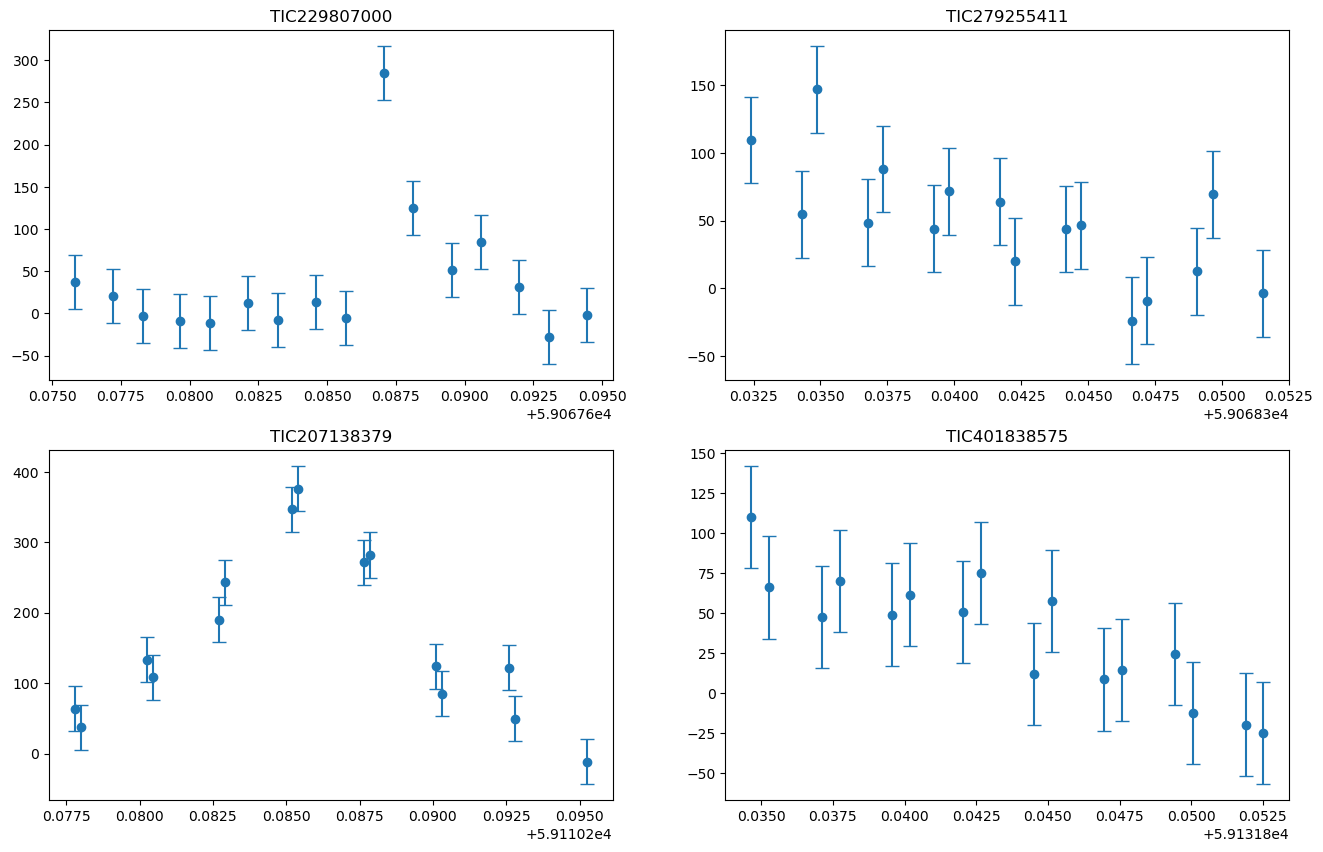

In [6]:
fig = plt.figure(figsize= (16,10))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.2, hspace=0.2)

for i, flare in coinciding_flares_df.iterrows():
    spt_id = flare['spt_id']
    TIC = flare['TIC']
    lc_idx = np.where(spt_ids == spt_id)[0][0]
    print(lc_idx)

    ax = fig.add_subplot(gs[int(i/2), int(i%2)])
    ax.errorbar(spt_times[lc_idx], spt_flux[lc_idx], yerr= 32*np.ones_like(np.abs(spt_flux_err[lc_idx])), fmt='o', capsize=5) #flux error currently hardcoded in as 32 mJy
    ax.set_title(TIC)


### Grab TESS LCs - TESSReduce

2 - TIC207138379
getting TPF from TESScut
made reference
made source mask
calculating background
background subtracted
aligning images
!!Re-running for difference image!!
shifting images
remade mask
background
background correlation correction
field calibration
target is below -30 dec, calibrating to SkyMapper photometry.


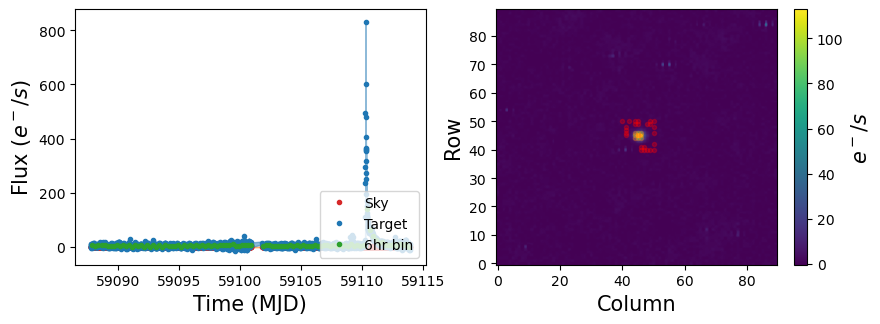

Pickling
Verifying Pickle
3 - TIC401838575
getting TPF from TESScut
made reference
made source mask
calculating background


KeyboardInterrupt: 

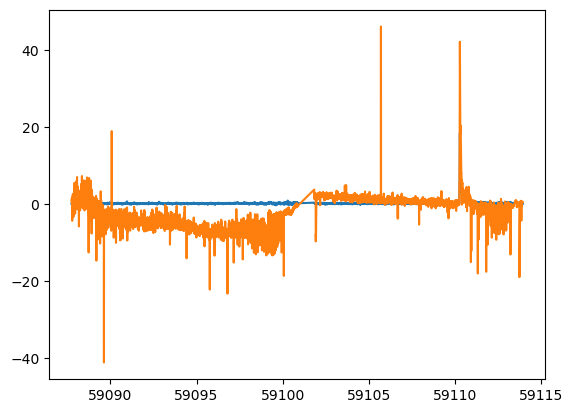

In [ ]:
for i, flare in coinciding_flares_df.iterrows():
    if (i == 0 or i == 1 or i == 3): continue
    print(i, '-', flare['TIC'])
    ra = flare['ra']
    if ra < 0: ra += 360
    dec = flare['dec']
    sectors = flare['sectors']
    tess_obs = tr.tessreduce(ra= ra, dec= dec, sector = sectors[0])
    # tess_obs.reduce()

    tess_obs.to_flux()
    lc = tess_obs.lc
    lc.shape
    plt.plot(lc[0], lc[1])

    print("Pickling")
    dbfile = open(f'{flare["TIC"]}_TR_LC', 'ab')
    pickle.dump(lc, dbfile)
    dbfile.close()

    print("Verifying Pickle")
    dbfile = open(f'{flare["TIC"]}_TR_LC', 'rb')
    lc = pickle.load(dbfile)
    dbfile.close()
    plt.plot(lc[0], lc[1])

In [19]:
flare = coinciding_flares_df.iloc[2]
print(flare['TIC'])
ra = flare['ra']
if ra < 0: ra += 360
dec = flare['dec']
sectors = flare['sectors']
tess_obs = tr.tessreduce(ra= ra, dec= dec, sector = sectors[0], reduce= False)
t = tess_obs.tpf.time
print((t[1] - t[0]) * 24 * 3600)
tess_obs.tpf
# tess_obs.to_flux()
# lc = tess_obs.lc
# plt.plot(lc[0], lc[1])

TIC207138379
getting TPF from TESScut
600.0124117170344


TessTargetPixelFile(TICID: 43.88514, -57.049441)

In [ ]:
flare = coinciding_flares_df.iloc[2]
print(flare['TIC'])
ra = flare['ra']
if ra < 0: ra += 360
dec = flare['dec']
sectors = flare['sectors']
c = SkyCoord(ra=float(ra)*u.degree, dec=float(dec)*u.degree, frame='icrs')
tess = lk.search_tesscut(c,sector=sectors[0])
print(type(tess))
print(tess)
tpf = tess.download()
print(type(tpf))
print((tpf.time[1] - tpf.time[0]) * 24 *60 * 60)
tpf

TIC207138379
<class 'lightkurve.search.SearchResult'>
SearchResult containing 1 data products.

 #     mission     year  author exptime     target_name      distance
                                   s                          arcsec 
--- -------------- ---- ------- ------- -------------------- --------
  0 TESS Sector 29 2020 TESScut     475 43.88514, -57.049441      0.0
<class 'lightkurve.targetpixelfile.TessTargetPixelFile'>
600.0124117170344


TessTargetPixelFile(TICID: 43.88514, -57.049441)

#### From manually downloaded TPF

In [103]:
fits_file = 'TIC207138379_TPF.fits'
fits.info(fits_file)
print(fits.getdata(fits_file, ext=1).columns)
hdul2 = fits.open("TIC207138379_TPF.fits")
ttpf = lk.TessTargetPixelFile(fits_file)

Filename: TIC207138379_TPF.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  PIXELS        1 BinTableHDU    248   18864R x 11C   [D, E, J, 121J, 121E, 121E, 121E, 121E, J, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   
  3  TARGET COSMIC RAY    1 BinTableHDU     27   0R x 4C   [J, I, I, E]   
ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '121J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(11,11)'
    name = 'FLUX'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_ERR'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_BKG'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_BKG_ERR'; format = '121E'; unit = 'e-

TIC207138379
Unlikely to get good shifts from a small tpf, so shift has been set to False
made reference
made source mask
calculating background
Small tpf, using percentile cut background
background subtracted
!!Re-running for difference image!!
remade mask
background
Small tpf, using percentile cut background
background correlation correction
field calibration
target is below -30 dec, calibrating to SkyMapper photometry.
!!!WARNING!!! field calibration is unreliable, using the default zp = 20.44
Traceback (most recent call last):
  File "c:\Users\vishi\miniconda3\envs\SPT_Flares\lib\site-packages\tessreduce\tessreduce.py", line 1893, in reduce
    self.lc, self.sky = self.diff_lc(plot=self.plot,diff=self.diff,tar_ap=tar_ap,sky_in=sky_in,sky_out=sky_out)
  File "c:\Users\vishi\miniconda3\envs\SPT_Flares\lib\site-packages\tessreduce\tessreduce.py", line 1165, in diff_lc
    self.dif_diag_plot(ap_tar,ap_sky,lc = lc,sky=sky,data=data)
  File "c:\Users\vishi\miniconda3\envs\SPT_Flares\lib\

<TimeDelta object: scale='tdb' format='jd' value=120.00262312794803>

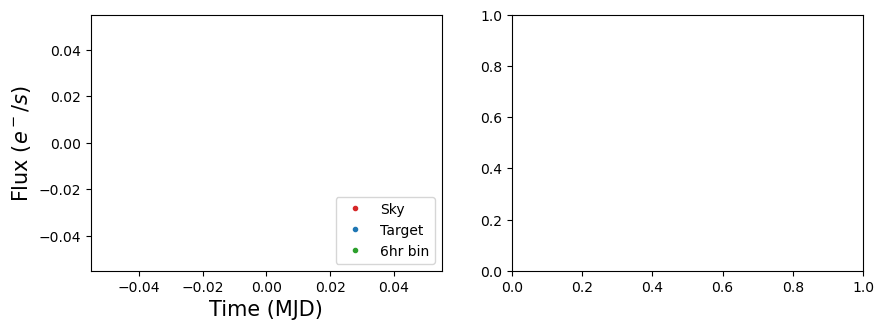

In [110]:
flare = coinciding_flares_df.iloc[2]
print(flare['TIC'])
ra = flare['ra']
if ra < 0: ra += 360
dec = flare['dec']
sectors = flare['sectors']
tess_obs = tr.tessreduce(ra= ra, dec= dec, sector = sectors[0], tpf= ttpf)
t = tess_obs.tpf.time
(t[1] - t[0]) * 24 * 3600

In [111]:
print("Flux NaNs in data:", np.sum(np.isnan(tess_obs.tpf.flux)))
print("Background NaNs in bkg:", np.sum(np.isnan(tess_obs.bkg)))
print("Zero fluxes in data:", np.sum(tess_obs.tpf.flux == 0))
print("Zero background in bkg:", np.sum(tess_obs.bkg == 0))

Flux NaNs in data: 0
Background NaNs in bkg: 2169409
Zero fluxes in data: 2
Zero background in bkg: 0


SearchResult containing 2 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 29 2020      SPOC     120   207138379      0.0
  1 TESS Sector 29 2020 TESS-SPOC     600   207138379      0.0
TessTargetPixelFile(TICID: 207138379)
TPF Flux Shape: (17929, 11, 11)
Unlikely to get good shifts from a small tpf, so shift has been set to False
made reference
made source mask
calculating background
Small tpf, using percentile cut background
background subtracted
field calibration
target is below -30 dec, calibrating to SkyMapper photometry.
!!!WARNING!!! field calibration is unreliable, using the default zp = 20.44
Traceback (most recent call last):
  File "c:\Users\vishi\miniconda3\envs\SPT_Flares\lib\site-packages\tessreduce\tessreduce.py", line 1893, in reduce
    self.lc, self.sky = self.diff_lc(plot=self.plot,diff=self.diff,ta

<TimeDelta object: scale='tdb' format='jd' value=120.00262312794803>

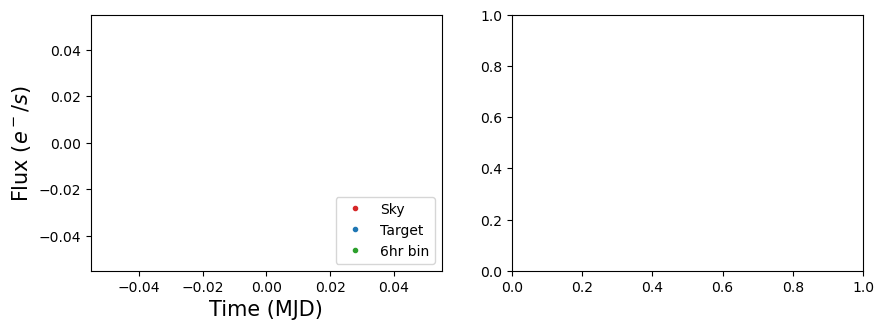

In [64]:
lc_file = lk.search_targetpixelfile('TIC207138379', mission= 'TESS', sector= 29)
print(lc_file)
tf = lc_file[0].download()
print(tf)
print("TPF Flux Shape:", tf.flux.shape)
if np.all(tf.flux == 0):
    print("Warning: All flux values in the TPF are zero. Check if this is the right data.")
tess_obs = tr.tessreduce(tpf= tf, diff= False)
t = tess_obs.tpf.time
(t[1] - t[0]) * 24 * 3600

In [78]:
diff_lc_result = tess_obs.diff_lc()
print("Data shape:", diff_lc_result[0].shape)  # Check if it's (0, 11, 11)
print("Sky median:", np.nanmedian(tess_obs.sky) if tess_obs.sky is not None else "Background is None")
tess_obs.ref

Data shape: (3, 17929)
Sky median: Background is None


array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
      dtype=float32)

### Some systems selected from Guns 2021 - Lightkurve

7 - WISE J025531.87-570252.3 | TIC207138379 | SPT-SV J025532.4-570257

6 - CC ERI | TIC142206123

8 - UCAC3 53-724 | TIC425937691

In [ ]:
obj = lk.search_lightcurve('TIC207138379', mission= 'TESS', author= 'TESS-SPOC')
res_2020 = np.where(obj.table['year'] == 2020)

lightcurves = obj[res_2020].download_all()
lightcurves.plot()

obj[res_2020]

# Overlay TESS and SPT

In [100]:
TIC = 'TIC207138379' # 'TIC207138379', 'TIC229807000', 'TIC279255411', 'TIC401838575'

46
SPOC


(59110.26532407407, 59110.30525462963)

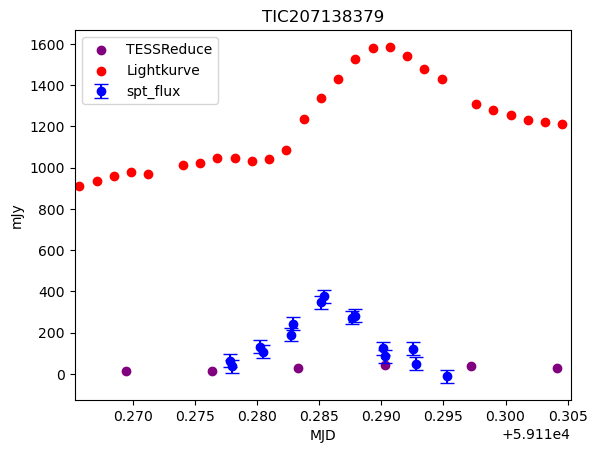

In [101]:
#SPT Single Scan
target_data = coinciding_flares_df[coinciding_flares_df['TIC'] == TIC]
target_data
spt_id = target_data['spt_id'].iloc[0]
lc_idx = np.where(spt_ids == spt_id)[0][0]
print(lc_idx)
plt.errorbar(spt_times[lc_idx], spt_flux[lc_idx], yerr= 32*np.ones_like(np.abs(spt_flux_err[lc_idx])),c= 'b', fmt='o', capsize=5, label= 'spt_flux') #flux error currently hardcoded in as 32 mJy

#TESSReduce
dbfile = open(f'{TIC}_TR_LC', 'rb')
TR_lc = pickle.load(dbfile)
dbfile.close()
plt.scatter(TR_lc[0], TR_lc[1], c= 'purple', label= 'TESSReduce')

#Lightkurve 
'''REWORK THIS SEARCH LOGIC'''
obj = lk.search_lightcurve(TIC, mission= 'TESS', sector= target_data["sectors"].iloc[0][0])
flare_obs = obj[0].download()
print(flare_obs.author)
qual = flare_obs.quality.value
time = np.array(flare_obs.time.value)
time = time[qual ==0]
sap_flux = np.array(flare_obs.sap_flux.value)
sap_flux = sap_flux[qual ==0]
time += 2457000.0 - 2400000.5
plt.scatter(time,sap_flux, c= 'r', label= 'Lightkurve')

plt.title(TIC)
plt.ylabel('mJy')
plt.xlabel('MJD')
plt.legend()
plt.xlim(np.min(spt_times[lc_idx])-0.01,np.max(spt_times[lc_idx])+0.01)

In [102]:
print('spt time resolution', (spt_times[lc_idx][1]-spt_times[lc_idx][0]) * 24 * 60 * 60)
print('SPOC time resolution', (time[1] - time[0]) * 24 * 60 * 60)
print('TESSReduce time resolution', (TR_lc[0][1] - TR_lc[0][0]) * 24 * 60 * 60)

spt time resolution 18.000000435858965
SPOC time resolution 120.00262308865786
TESSReduce time resolution 600.0124119920656


In [ ]:
wise = coinciding_flares_df.iloc[2]
ra = wise['ra']
dec = wise['dec']
sector = wise['sectors'][0]
print(wise['TIC'])
c = SkyCoord(ra, dec, frame= 'icrs', unit= 'deg')
tess = lk.search_tesscut(c,sector=sector)
tpf = tess.download()
tpf.flux.shape